In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors
import torch.nn.functional as F

from torchvision.utils import make_grid

import random
import os
from itertools import product

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
# Die ersten beiden leaning Raten waren zu hoch, erste bei der letzen hat es funktioniert
# Wahrscheinlich ist das problem unabhängig von der Distance der Loss-function

batch_size: int = 32
#learning_rate: int = 0.001
#learning_rate: int = 0.0005
learning_rate: int = 0.00001

path_mnist_data: str = '/..Autoencoder/data'

device: str = "mps" if torch.backends.mps.is_available() else "cpu"
device: torch.device = torch.device(device)

In [3]:
data = np.load('Siamese/label_0.npz')
embedding_0_label = data['embedding_0_label']
data = np.load('Siamese/label_9.npz')
embedding_9_label = data['embedding_9_label']
data = np.load('Siamese/unlabel_0.npz')
embedding_0_unlabel = data['embedding_0_unlabel']
data = np.load('Siamese/unlabel_9.npz')
embedding_9_unlabel = data['embedding_9_unlabel']

In [4]:
gelabeld = np.append(embedding_0_label, embedding_9_label, axis=0)
labels = [0] * len(embedding_0_label) + [1] * len(embedding_9_label)

5329
5329
-------------------
[-10.49112     -3.1411314   27.882671   -11.423933    -9.819811
  -3.71013     -3.9461176   -5.8471127   29.130749   -28.617287
 -24.842371    24.429653   -11.249052    -0.46249074  -4.1258607
 -32.20708      1.1396779    1.1749896  -21.92912     -4.919338
  -0.09613742   3.6847212   -5.9388227  -14.173212    20.944077
  28.446772   -27.480078    19.393602     2.1865911    2.768881
   8.3692875   24.884724  ]
<class 'numpy.ndarray'>
10658


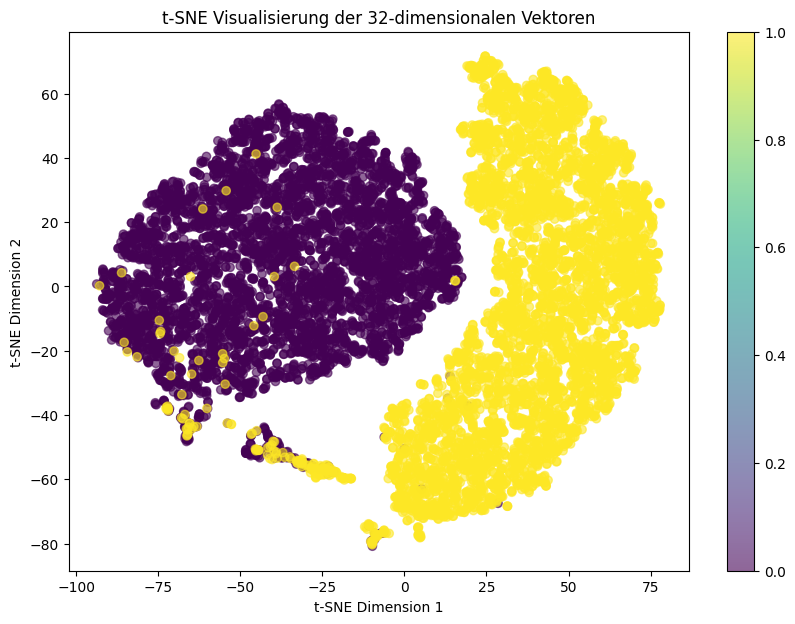

In [5]:


print(len(embedding_0_label))
print(len(embedding_9_label))
print('-------------------')
print(gelabeld[0])
print(type(gelabeld))
print(len(gelabeld))
#print(shape)

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(gelabeld)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

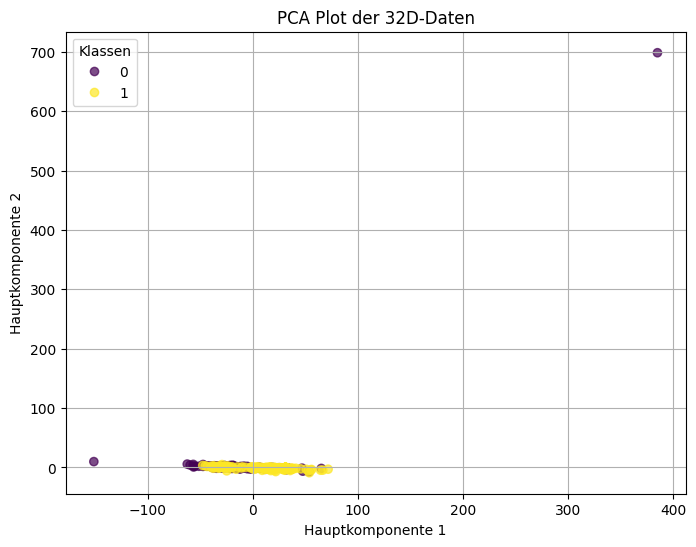

In [14]:
# PCA durchführen, um die Dimensionen von 32 auf 2 zu reduzieren
pca = PCA(n_components=2)
X_pca = pca.fit_transform(gelabeld)

# Plotten der PCA-Ergebnisse
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)

# Legende hinzufügen
legend1 = plt.legend(*scatter.legend_elements(), title="Klassen")

# Plot-Anpassungen
plt.title('PCA Plot der 32D-Daten')
plt.xlabel('Hauptkomponente 1')
plt.ylabel('Hauptkomponente 2')
plt.grid(True)
plt.show()

In [6]:
class Embeded_Database(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        vector = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(vector, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [7]:
train_data = Embeded_Database(gelabeld, labels)
train_loader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle=True,
)

In [8]:
class Classifier_network(nn.Module):
    def __init__(self) -> None:
        super(Classifier_network, self).__init__()
        self.fc1 = nn.Linear(32, 10)
        self.fc2 = nn.Linear(10, 1)
    
    
    def forward(self, x) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
        

classifier_network: Classifier_network = Classifier_network()#.to(device)
print(classifier_network)

Classifier_network(
  (fc1): Linear(in_features=32, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [9]:
print(f'Output Size der einzelnen layern im Encoder')
input_tensor_network = torch.randn(32,32)
with torch.no_grad():
    output = input_tensor_network
    for name, layer in classifier_network.named_children():
        output = layer(output)
        print(f"{name}: {output.size()}")

Output Size der einzelnen layern im Encoder
fc1: torch.Size([32, 10])
fc2: torch.Size([32, 1])


In [10]:
optimizer_classifier = torch.optim.Adam(classifier_network.parameters(), lr=learning_rate)

loss_classifier = F.mse_loss

list_epoch_loss = [] 
loss_iteration = []
for epoch in range(40):
    print(f'----------------Start trainign Epoche {epoch}----------------')
    epoch_loss: float = 0.0
    for embed, lab in train_loader:
        lab = lab.unsqueeze(1)
        #embed, label = embed.to(device), label.to(device)
        out = classifier_network(embed)
        #label = label.float() -> Datentyp in Dataclass angepasst
        #out = out.to(torch.float)

        loss = loss_classifier(out, lab)
        loss.backward()
        optimizer_classifier.step()
        iteration_loss = loss.item()
        loss_iteration.append(iteration_loss)

        epoch_loss += iteration_loss

    list_epoch_loss.append(epoch_loss/len(train_loader))
    print(f'Epoche: {epoch} Average Loss: {epoch_loss/len(train_loader)}')

----------------Start trainign Epoche 0----------------
Epoche: 0 Average Loss: 0.19760170556649476
----------------Start trainign Epoche 1----------------
Epoche: 1 Average Loss: 0.18488412925940073
----------------Start trainign Epoche 2----------------
Epoche: 2 Average Loss: 0.17067561635446404
----------------Start trainign Epoche 3----------------
Epoche: 3 Average Loss: 0.1570813957668707
----------------Start trainign Epoche 4----------------
Epoche: 4 Average Loss: 0.14402304074453737
----------------Start trainign Epoche 5----------------
Epoche: 5 Average Loss: 0.131641966340963
----------------Start trainign Epoche 6----------------
Epoche: 6 Average Loss: 0.11911743462174952
----------------Start trainign Epoche 7----------------
Epoche: 7 Average Loss: 0.10754192392983122
----------------Start trainign Epoche 8----------------
Epoche: 8 Average Loss: 0.0969837705219934
----------------Start trainign Epoche 9----------------
Epoche: 9 Average Loss: 0.08665924843869166
----

In [31]:
unlabeld = np.append(embedding_0_unlabel, embedding_9_unlabel, axis=0)
y_true = [0] * len(embedding_0_unlabel) + [1] * len(embedding_9_unlabel)

test_data = Embeded_Database(gelabeld, labels)
test_loader = DataLoader(
    dataset = test_data,
    batch_size = batch_size,
)

y_pred = []
for emb, _ in test_loader:
    out = classifier_network(emb)
    out = out.to("cpu").detach().numpy()
    y_pred.extend(out)

print(type(y_true))
print(type(y_pred))
print(len(y_true))
print(len(y_pred))

<class 'list'>
<class 'list'>
10658
10658


In [33]:
roc = roc_auc_score(y_true, y_pred, multi_class='ovr')
pr = average_precision_score(y_true, y_pred)

print(f'ROC-AUC: {roc}')
print(f'ROC_PR: {pr}')

ROC-AUC: 0.992456064444273
ROC_PR: 0.9882560160987062


torch.Size([10000, 1])
<class 'numpy.ndarray'>
10000


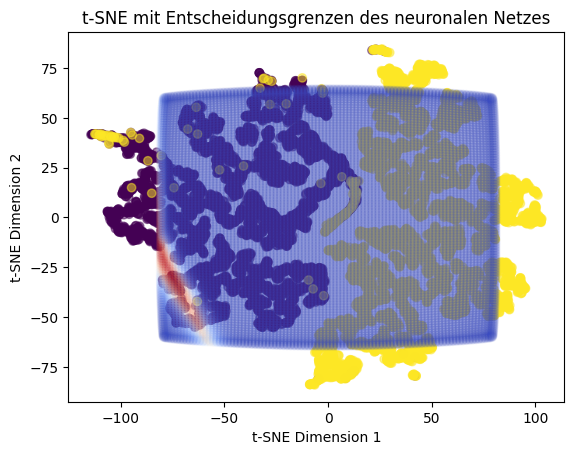

In [13]:
# Angenommen, X sind die 32D-Daten und y sind die zugehörigen Labels
#X = np.random.rand(100, 32)  # Beispiel-Daten
#y = np.random.randint(0, 2, 100)  # Beispiel-Labels

X = gelabeld
y = labels

# Trainieren des neuronalen Netzes
#model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
#model.fit(X, y)

# Dimensionen mit PCA auf 2 reduzieren
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE-Transformation der PCA-Daten
X_tsne = TSNE(n_components=2).fit_transform(X_pca)

# Erstellen eines 2D-Grids im PCA-Raum
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# In den ursprünglichen 32D-Raum zurückprojizieren
grid_original_space = pca.inverse_transform(grid)
grid_original_space_tensor = torch.tensor(grid_original_space, dtype=torch.float32)

# Vorhersage des neuronalen Netzes auf dem Grid
grid_predictions = classifier_network.forward(grid_original_space_tensor)
print(grid_predictions.shape)
grid_predictions = grid_predictions.to("cpu").detach().numpy()
print(type(grid_predictions))
print(len(grid_predictions))

# t-SNE-Transformation des Grids
grid_tsne = TSNE(n_components=2).fit_transform(grid_original_space)

# Plotten der t-SNE-Datenpunkte
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5)

# Plotten der t-SNE-Gridpunkte als Entscheidungsgrenzen
plt.scatter(grid_tsne[:, 0], grid_tsne[:, 1], c=grid_predictions, cmap='coolwarm', alpha=0.1)

plt.title('t-SNE mit Entscheidungsgrenzen des neuronalen Netzes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [19]:
# Angenommen, X sind die 32D-Daten und y sind die zugehörigen Labels
X = gelabeld
y = labels

# t-SNE-Transformation der Daten
X_embedded = TSNE(n_components=2).fit_transform(X)

# Erstellen eines 32D-Grids
grid_size = 5
grid = np.array(np.meshgrid(*[np.linspace(np.min(X[:, i]), np.max(X[:, i]), grid_size) for i in range(X.shape[1])])).T.reshape(-1, X.shape[1])

# Vorhersage des neuronalen Netzes auf dem Grid
grid_predictions = classifier_network.forward(grid)

# t-SNE-Transformation des Grids
grid_embedded = TSNE(n_components=2).fit_transform(grid)

# Plotten der t-SNE-Datenpunkte
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.5)

# Plotten der t-SNE-Gridpunkte als Entscheidungsgrenzen
plt.scatter(grid_embedded[:, 0], grid_embedded[:, 1], c=grid_predictions, cmap='coolwarm', alpha=0.1)

plt.title('t-SNE mit Entscheidungsgrenzen des neuronalen Netzes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

ValueError: broadcast dimensions too large.